# Projeto Integrado - Deep Learning

## MBA em Ciência de Dados e Inteligência Artificial - FIAP - 2024

## Descrição do Projeto:

A QuantumFinance está desejando construir um fundo de ações baseado em modelos de Deep Learning. A ideia é desenvolver um modelo que tenha como saída a compra ou venda de uma determinada ação baseado na movimentação do mercado nos últimos 15 dias.

Esse notebook contempla a ação VALE3 - Vale do Rio Doce para análise e montagem dos modelos.

## O Desafio: 
A empresa deseja um modelo de Deep Learning que seja um ‘perseguidor de tendencia’, ou seja, se o papel sobe o modelo deve comprar, se o papel desce o
modelo deve vender. Para isso a QuantumFinance contratou economistas que fizerem a rotulagem dos dados baseado no valor de fechamento dos ativos. Inicialmente foi feita uma suavização dos preços de fechamento, e por se tratar de um assunto sigiloso, não foi informada a técnica de suavização utilizada. O próximo passo foi realizar a rotulagem dia a dia, para verificar qual devemos comprar e qual devemos vender.

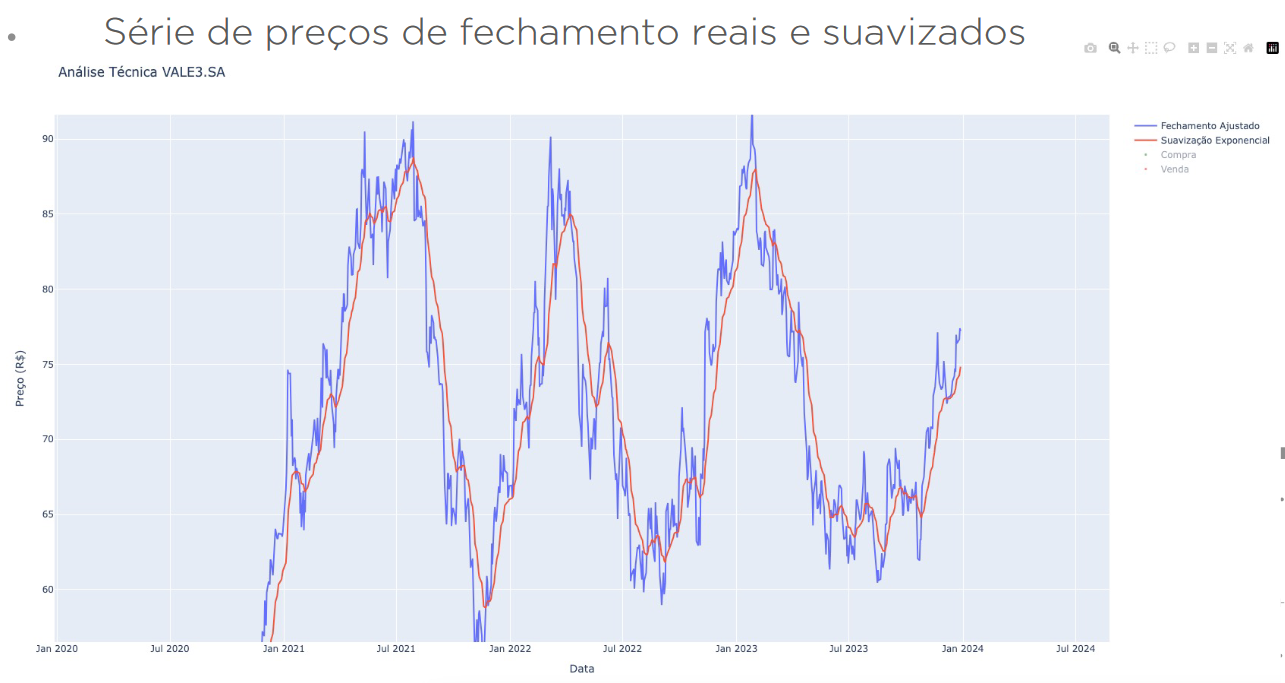

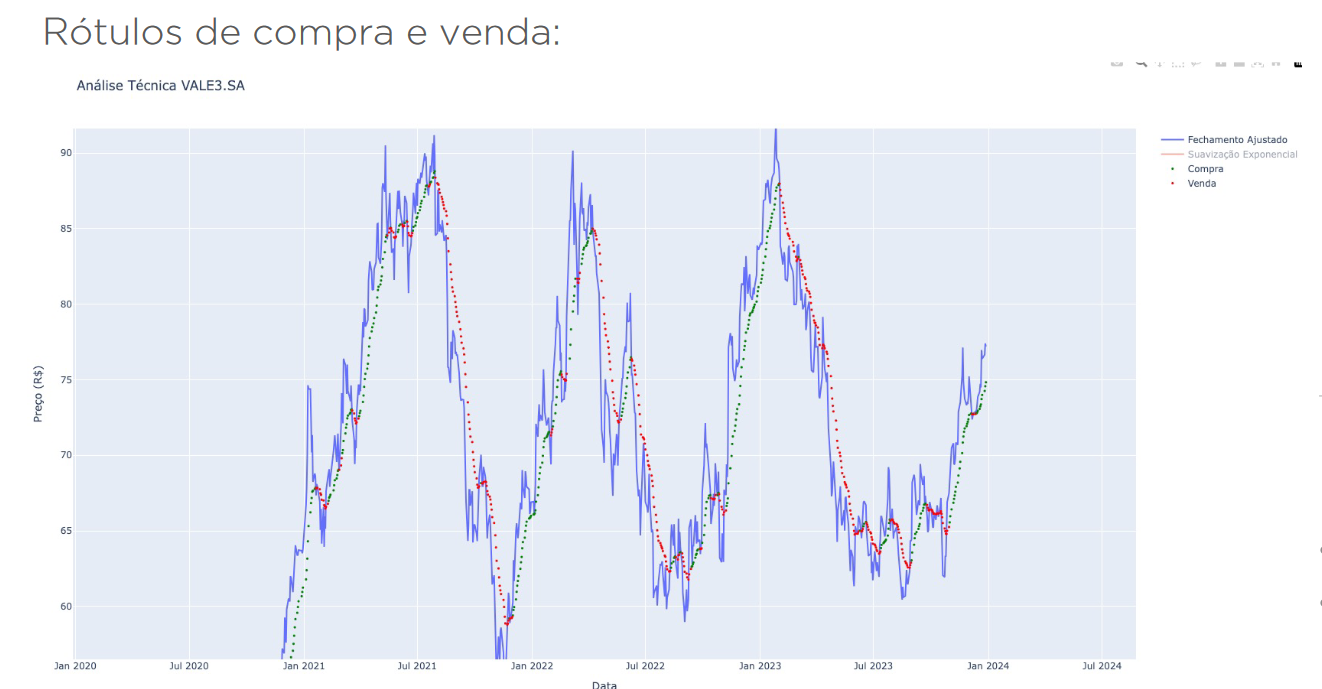

In [1]:
from pathlib import Path 

import numpy as np
import pandas as pd

import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import HeNormal

from scikeras.wrappers import KerasClassifier

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import warnings
warnings.filterwarnings('ignore')

import sys
import os

automations_dir = os.path.join(os.getcwd(), '../scripts')

if automations_dir not in sys.path:
    sys.path.append(automations_dir)

import cnn_trading_classifier as ctc

In [2]:
datapath = Path('../data')
modelpath = Path('../model')

In [3]:
data = pd.read_csv(f'{datapath}/csv/train.csv')
data = data[['Date', 'Smoothed_Close', 'Label']]
data.head()

,Date,Smoothed_Close,Label
0,2000-01-24,1.752574,1
1,2000-01-25,1.760229,1
2,2000-01-26,1.765594,1
3,2000-01-27,1.771947,1
4,2000-01-28,1.777664,1


In [4]:
data_test = pd.read_csv(f'{datapath}/csv/test.csv')
data_test = data_test[['Smoothed_Close', 'Label']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4808 entries, 0 to 4807
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4808 non-null   object 
 1   Smoothed_Close  4808 non-null   float64
 2   Label           4808 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 112.8+ KB


In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

In [7]:
fig = go.Figure()

for year in data['Year'].unique():
    year_data = data[data['Year'] == year]
    fig.add_trace(go.Scatter(x=year_data['Date'], y=year_data['Smoothed_Close'],
                             mode='lines', name=str(year)))

for label, name, color in zip([-1, 1], ['Venda', 'Compra'], ['red', 'green']):
    label_data = data[data['Label'] == label]
    fig.add_trace(go.Scatter(x=label_data['Date'], y=label_data['Smoothed_Close'],
                             mode='markers', name=name, marker_color=color))

fig.update_layout(title='VALE3 - Vale do Rio Doce',
                  xaxis_title='Anos',
                  yaxis_title='Preços de Fechamento',
                  legend_title='Legenda')

fig.show()

In [8]:
data.drop(['Date', 'Year'], axis=1, inplace=True)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(data[['Smoothed_Close']])
scaled_close_test = scaler.transform(data_test[['Smoothed_Close']])

In [10]:
data['Scaled_Close'] = scaled_close.flatten()
data_test['Scaled_Close'] = scaled_close_test.flatten()

In [11]:
def create_window(data, label, window_size=15):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        window = np.expand_dims(window, axis=-1)
        X.append(window)
        y.append(label[i + window_size])
    return np.array(X), np.array(y)

In [12]:
X_train, y_train = create_window(data=data['Scaled_Close'], label=data['Label'], window_size=15)
X_test, y_test = create_window(data=data['Scaled_Close'], label=data['Label'], window_size=15)

In [13]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = f'{modelpath}/pesos.h5', monitor = 'loss', save_best_only = True, verbose = 1)

In [14]:
def objective(params):
    classificador = KerasClassifier(build_fn=lambda: ctc.rede_cnnTrading(params), epochs=10, batch_size=128, verbose=0, callbacks=[es, rlr, mcp])
    classificador.fit(X_train, y_train)
    score = classificador.score(X_test, y_test)
    return {'loss': -score, 'status': STATUS_OK}

In [15]:
space = {
    'filters': hp.choice('filters', [32, 64]),
    'kernel_size': hp.choice('kernel_size', [1, 3, 5]),
    'pool_size': hp.choice('pool_size', [1, 2, 3]),
    'lstm_units': hp.choice('lstm_units', [50, 100]),
    'dropout_rate': hp.uniform('dropout_rate', 0, 1),
    'l1': hp.loguniform('l1', 0, 0.01),
    'l2': hp.loguniform('l2', 0, 0.01),
    'loss': hp.choice('loss', ['binary_crossentropy', 'hinge']),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'kernel_initializer': hp.choice('kernel_initializer', [HeNormal(), 'glorot_uniform'])
}

In [ ]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
print(best)